CT-HMM Library 
============================
The document contain the tutorial ( usage explained by example ) for the hidden markov models library [link to pip].
* The **first** part will cover disrete-time hidden markov model (**HMM**)
* The **second** part will be dedicated to continuous-time hidden markov model (**CT-HMM**)

If you are not familiar with the hidden markov model theory, We recommend ...
%todo: refer to DP theory, github, sources

Part 1: Hidden Markov Model
---------------------------------



In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cthmm

%matplotlib inline

### Create HMM By Own Defined Parameters 
We will create simple HMM of two hidden states and three output variables.

In [15]:
# A is the matrix of transition probabilities from state [row] to state [column].
A = np.array([[0.9,0.1],[0.4,0.6]])
# B is the matrix of probabilities that the state [row] will emmit output variable [column].
B = np.array([[0.9,0.08,0.02],[0.2,0.5,0.3]])
# pi is the vector of initial state probabilities.   
pi = np.array( [0.8,0.2] )

# Create HMM by given parameters.
hmm = cthmm.HMM(A,B,pi)

### Generate Random State and Emission Sequence
 Now we can use our model to generate state and emission sequence.   
 The model will randomly choose which transition or emission will happen, taking into consideration the parameters we have previously defined.


In [67]:
seq_len = 20 
s_seq, e_seq = hmm.generate( seq_len )
s_seq, e_seq

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0]))

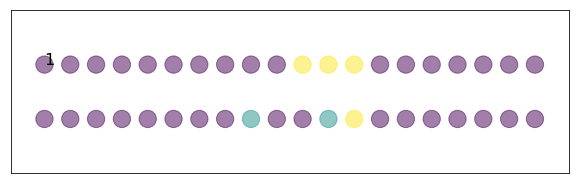

In [82]:
n = e_seq.shape[0]
X = np.arange(n)
Y0 = np.zeros(n)
Y1 = np.ones(n) 

plt.xticks([])
plt.ylim(-1,2), plt.yticks([])

plt.scatter(X,Y1, s=300, c=s_seq, alpha=.5)
plt.scatter(X,Y0, s=300, c=e_seq, alpha=.5)

plt.rcParams["figure.figsize"] = [n/2,3]

plt.annotate(r'1',
             xy=(0, 1), xycoords='data',
             xytext=(0, 0), textcoords='offset points', fontsize=16 )
            

plt.show()


In [71]:
X


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])